# Survival Classification - Top 10 Features

This notebook trains a Random Forest model on the top 10 most important features and evaluates its performance.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt
import pickle

In [2]:
file_path = "zincphosph1.xlsx"

xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names

dfs = [pd.read_excel(xls, sheet_name=sheet) for sheet in sheet_names]
df_full = pd.concat(dfs, axis=1)

print("✅ Data loaded successfully. Shape:", df_full.shape)
df_full.head()

✅ Data loaded successfully. Shape: (66, 77)


,poison severity score,NE_given (Norepinephrine),NaHCO3_given (Sodium Bicarbonate),Age (in years),"Sex (1=Male, 2=Female)","Time_since_exposure (1=0.5-1h, 2=1-3h, 3=>3h)","Exposure_condition (1=Newly opened, 2=Exposed to moisture)","Delivery_method (1=Ingested directly, 2=Dissolved in water, 3=On food)",Dose_taken (in sachets),Nausea,...,NLR_interpret,Platelets (x10^3),PLR (Platelet-to-Lymph Ratio),PLR_interpret,"Survival (1=Survived, 0=Died)",Hospital_stay_days,Ventilation_days,ICU_stay_days,"Need_vasopressors (1=Yes, 0=No)",NE_total_dose_at_discharge
0,1,0,0,29.0,1,1,1,2,1.00,1,...,3,287,134.230,1,1,2,0,0,0,0
1,1,0,0,18.0,2,1,1,2,1.00,1,...,1,267,117.828,1,1,2,0,0,0,0
2,1,0,0,19.0,1,3,1,1,1.00,1,...,1,289,129.420,1,1,3,0,0,0,0
3,1,0,0,21.0,2,2,1,1,1.00,1,...,1,281,104.400,1,1,2,0,0,0,0
4,1,0,0,15.0,2,2,1,1,0.25,1,...,1,300,127.060,1,1,3,0,0,0,0


In [3]:
target_col = "Survival (1=Survived, 0=Died) "

y = df_full[target_col]
X = df_full.drop(columns=[target_col])

columns_to_exclude = [
    "Hospital_stay_days", "Ventilation_days", "ICU_stay_days", "Need_vasopressors (1=Yes, 0=No)", "NE_total_dose_at_discharge",
    "last_PH", "last_PH_interpret", "last_PCO2", "last_PCO2_interpret", "last_HCO3", "last_HCO3_interpret",
    "discharge_BP_systolic", "discharge_BP_systolic_interpret", "discharge_BP_diastolic", "discharge_BP_diastolic_interpret",
    "discharge_BP_mean", "discharge_BP_mean_interpret", "discharge_RR", "discharge_RR_interpret",
    "discharge_PULSE", "discharge_PULSE_interpret"
]

X_cleaned = X.drop(columns=[col for col in columns_to_exclude if col in X.columns], errors='ignore')

interpret_cols = [col for col in X_cleaned.columns if 'interpret' in col.lower()]
X_cleaned = X_cleaned.drop(columns=interpret_cols)

print("✅ Columns before exclusion:", X.shape[1])
print("✅ Columns after exclusion:", X_cleaned.shape[1])

✅ Columns before exclusion: 76
✅ Columns after exclusion: 36


In [4]:
X_encoded = X_cleaned.copy()
for col in X_encoded.columns:
    if X_encoded[col].dtype == 'object':
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

df_model = X_encoded.copy()
df_model['Survival'] = y.values

df_survived = df_model[df_model['Survival'] == 1]
df_died = df_model[df_model['Survival'] == 0]

df_died_upsampled = resample(
    df_died,
    replace=True,
    n_samples=len(df_survived),
    random_state=42
)

df_balanced = pd.concat([df_survived, df_died_upsampled])

X_balanced = df_balanced.drop(columns=['Survival'])
y_balanced = df_balanced['Survival']

print("✅ Class distribution after balancing:")
print(y_balanced.value_counts())

✅ Class distribution after balancing:
Survival
1    65
0    65
Name: count, dtype: int64


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

importances = model.feature_importances_
feat_importance = pd.Series(importances, index=X_balanced.columns).sort_values(ascending=False)

top_10_features = feat_importance.head(10).index.tolist()

print("✅ Top 10 most important features:")
print(top_10_features)

✅ Top 10 most important features:
['RDW', 'HS_Troponin', 'poison severity score ', 'NE_given (Norepinephrine)', 'Creatinine ', 'BP_mean', 'discharge_PULSE ', 'PLR (Platelet-to-Lymph Ratio)', 'RBS', 'K']


In [6]:
X_top10 = X_balanced[top_10_features]

X_train, X_test, y_train, y_test = train_test_split(
    X_top10, y_balanced, test_size=0.2, random_state=42
)

print("✅ Data shape after selecting top 10 features:")
print(X_train.shape, X_test.shape)

✅ Data shape after selecting top 10 features:
(104, 10) (26, 10)


In [7]:
model_final = RandomForestClassifier(n_estimators=100, random_state=42)
model_final.fit(X_train, y_train)

print("✅ Final model trained successfully.")

✅ Final model trained successfully.


In [8]:
y_pred = model_final.predict(X_test)

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print("✅ Evaluation Report:")
report_df

✅ Evaluation Report:


,precision,recall,f1-score,support
0,1.0,1.0,1.0,12.0
1,1.0,1.0,1.0,14.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,26.0
weighted avg,1.0,1.0,1.0,26.0


In [9]:
report_df.to_csv("classification_report_top10.csv")
with open("model_top10.pkl", "wb") as f:
    pickle.dump(model_final, f)

print("✅ Report saved as 'classification_report_top10.csv'")
print("✅ Model saved as 'model_top10.pkl'")

✅ Report saved as 'classification_report_top10.csv'
✅ Model saved as 'model_top10.pkl'


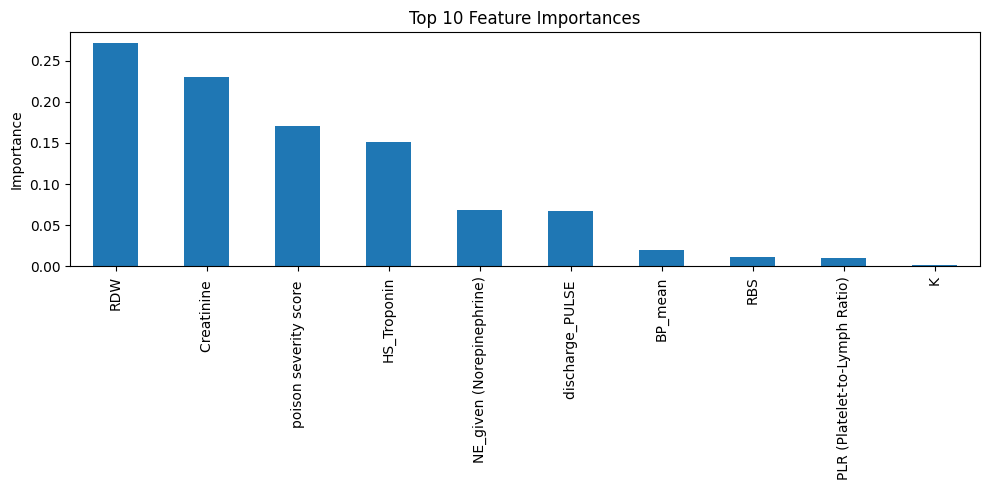

✅ Feature importance plot saved as 'feature_importance_top10.png'


In [10]:
importances = model_final.feature_importances_
feat_importance = pd.Series(importances, index=top_10_features).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
feat_importance.plot(kind='bar')
plt.title("Top 10 Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.savefig("feature_importance_top10.png")
plt.show()

print("✅ Feature importance plot saved as 'feature_importance_top10.png'")